# UNIVERSIDADE TIRADENTES

Alunos: Ian Sandes e José Everton


Disciplina: Machine Learning


Professor: Adolfo Guimarães

In [ ]:
# Imports necessários 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import plotly.graph_objects as go
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

# Sobre a base

Os dados disponíveis foram extraídos das soluções SinespJC e Sinesp Integração, fontes primárias dos seguintes indicadores: Totais de Ocorrências e Totais de Vítimas de estupro, furto de veículos, homicídio doloso, lesão corporal seguida de morte, roubo à instituição financeira, roubo de carga, roubo de veículos e roubo seguido de morte.


https://dados.mj.gov.br/dataset/sistema-nacional-de-estatisticas-de-seguranca-publica

# Pré-processamento da base

In [ ]:
# Carregando a base de dados 
dataset_brasil = pd.read_excel('indicadoressegurancapublicauf.xlsx')
dataset_brasil

,UF,Tipo Crime,Ano,Mês,Ocorrências
0,Acre,Estupro,2021,janeiro,39
1,Acre,Furto de veículo,2021,janeiro,55
2,Acre,Homicídio doloso,2021,janeiro,14
3,Acre,Lesão corporal seguida de morte,2021,janeiro,0
4,Acre,Roubo a instituição financeira,2021,janeiro,0
...,...,...,...,...,...
18769,Tocantins,Roubo a instituição financeira,2015,dezembro,6
18770,Tocantins,Roubo de carga,2015,dezembro,1
18771,Tocantins,Roubo de veículo,2015,dezembro,55
18772,Tocantins,Roubo seguido de morte (latrocínio),2015,dezembro,2


In [ ]:
dataset_pop = pd.read_csv('estadospopulacao.csv')
dataset_pop

,SIGLA,POPULAÇÃO
0,AC,790101
1,AL,3322000
2,AP,751000
3,AM,3874000
4,BA,15130000
5,CE,8843000
6,DF,3094325
7,ES,3885000
8,GO,6523000
9,MA,6851000


In [ ]:
dataset_brasil.columns
dataset_pop.columns

Index(['SIGLA', 'POPULAÇÃO'], dtype='object')

In [ ]:
# Agrupando os dados

estados = sorted(list(set(dataset_brasil['UF'])))

crimes = sorted(list(set(dataset_brasil['Tipo Crime'])))

df_brasil = pd.DataFrame()

df_brasil['UF'] = estados

for crime in crimes:
    ocorrencias_crime = []
    for estado in estados:
        crime_por_estado = dataset_brasil.loc[(dataset_brasil['Tipo Crime'] == crime) & (dataset_brasil['UF'] == estado)]
        valor = crime_por_estado["Ocorrências"].sum()
        ocorrencias_crime.append(valor)
    df_brasil[crime] = ocorrencias_crime


df_brasil['Populacao'] = dataset_pop['POPULAÇÃO'].astype('float64').apply(lambda x: x/1_000_000)
df_brasil['Sigla'] = dataset_pop['SIGLA']

df_brasil

,UF,Estupro,Furto de veículo,Homicídio doloso,Lesão corporal seguida de morte,Roubo a instituição financeira,Roubo de carga,Roubo de veículo,Roubo seguido de morte (latrocínio),Tentativa de homicídio,Populacao,Sigla
0,Acre,1264,2415,1902,8,13,8,4575,84,560,0.790101,AC
1,Alagoas,3858,7581,9020,62,98,423,18463,258,3416,3.322000,AL
2,Amapá,2328,3995,1630,111,59,31,2052,125,1388,0.751000,AP
3,Amazonas,5501,14875,6927,158,347,63,19152,403,1837,3.874000,AM
4,Bahia,18645,33522,35155,566,141,2149,82856,1046,16624,15.130000,BA
5,Ceará,10496,29472,23173,209,244,1219,57836,394,8258,8.843000,CE
6,Distrito Federal,4153,35329,2960,37,20,301,25971,215,5178,3.094325,DF
7,Espírito Santo,3928,28494,7648,84,153,161,26226,262,15551,3.885000,ES
8,Goiás,4124,62674,13204,257,299,2384,55521,496,13762,6.523000,GO
9,Maranhão,7905,17063,11692,174,415,293,25272,600,6814,6.851000,MA


# Análise dos dados

## Verificando a correlação entre os crimes

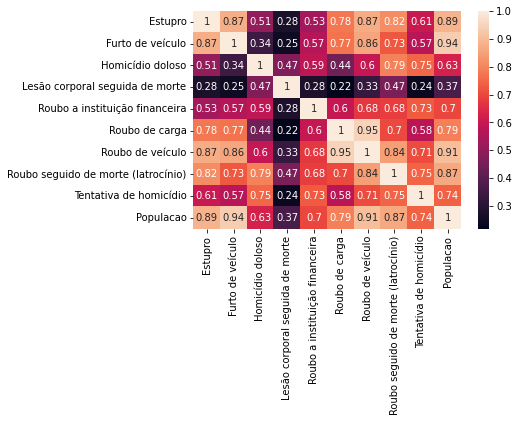

In [ ]:
df_brasil_corr = df_brasil[[*crimes, 'Populacao']].corr()
sns.heatmap(df_brasil_corr, xticklabels=[*crimes, 'Populacao'], yticklabels=[*crimes, 'Populacao'], annot=True)

### O que podemos concluir?
- Uma correlação alta que podemos identificar é entre Roubo de Carga e Roubo de veículo
- Outra correlação alta é entre Furto de veículo e estupro
- Existe uma correlação entre os tipos de crimes e a número da população, por exemplo, Furto e Roubo de veículos. E também número de estupros

--- 

Exibindo uma matriz de similaridade entre as instâncias com o intuito de verificar algum tipo de relação entre os estados a partir dos dados coletados.

A similaridade é baseada na distância entre as instâncias. Como essa métrica é influenciada pela escala dos valores, normalizaremos alguns dados.

In [ ]:
x = df_brasil[[*crimes, 'Populacao']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_brasil_norm = pd.DataFrame(x_scaled, index=df_brasil.UF, columns=[*crimes, 'Populacao'])
df_brasil_norm

,Estupro,Furto de veículo,Homicídio doloso,Lesão corporal seguida de morte,Roubo a instituição financeira,Roubo de carga,Roubo de veículo,Roubo seguido de morte (latrocínio),Tentativa de homicídio,Populacao
UF,,,,,,,,,,
Acre,0.000000,0.000000,0.020934,0.000000,0.000000,0.000092,0.006740,0.002980,0.000000,0.002987
Alagoas,0.037330,0.008489,0.230509,0.049815,0.172065,0.007754,0.043843,0.106675,0.118936,0.058032
Amapá,0.015312,0.002596,0.012925,0.095018,0.093117,0.000517,0.000000,0.027414,0.034481,0.002137
Amazonas,0.060975,0.020474,0.168885,0.138376,0.676113,0.001108,0.045684,0.193087,0.053180,0.070033
Bahia,0.250130,0.051115,1.000000,0.514760,0.259109,0.039620,0.215875,0.576281,0.668971,0.314748
Ceará,0.132857,0.044460,0.647215,0.185424,0.467611,0.022450,0.149032,0.187723,0.320576,0.178064
Distrito Federal,0.041576,0.054084,0.052085,0.026753,0.014170,0.005502,0.063902,0.081049,0.192312,0.053083
Espírito Santo,0.038338,0.042853,0.190113,0.070111,0.283401,0.002917,0.064583,0.109058,0.624287,0.070273
Goiás,0.041158,0.099017,0.353698,0.229705,0.578947,0.043959,0.142847,0.248510,0.549786,0.127625


In [ ]:
df_brasil_dist = pd.DataFrame(
    squareform(pdist(df_brasil_norm[[*crimes, 'Populacao']], metric='euclidean')),
    columns = df_brasil.Sigla,
    index = df_brasil.Sigla
)

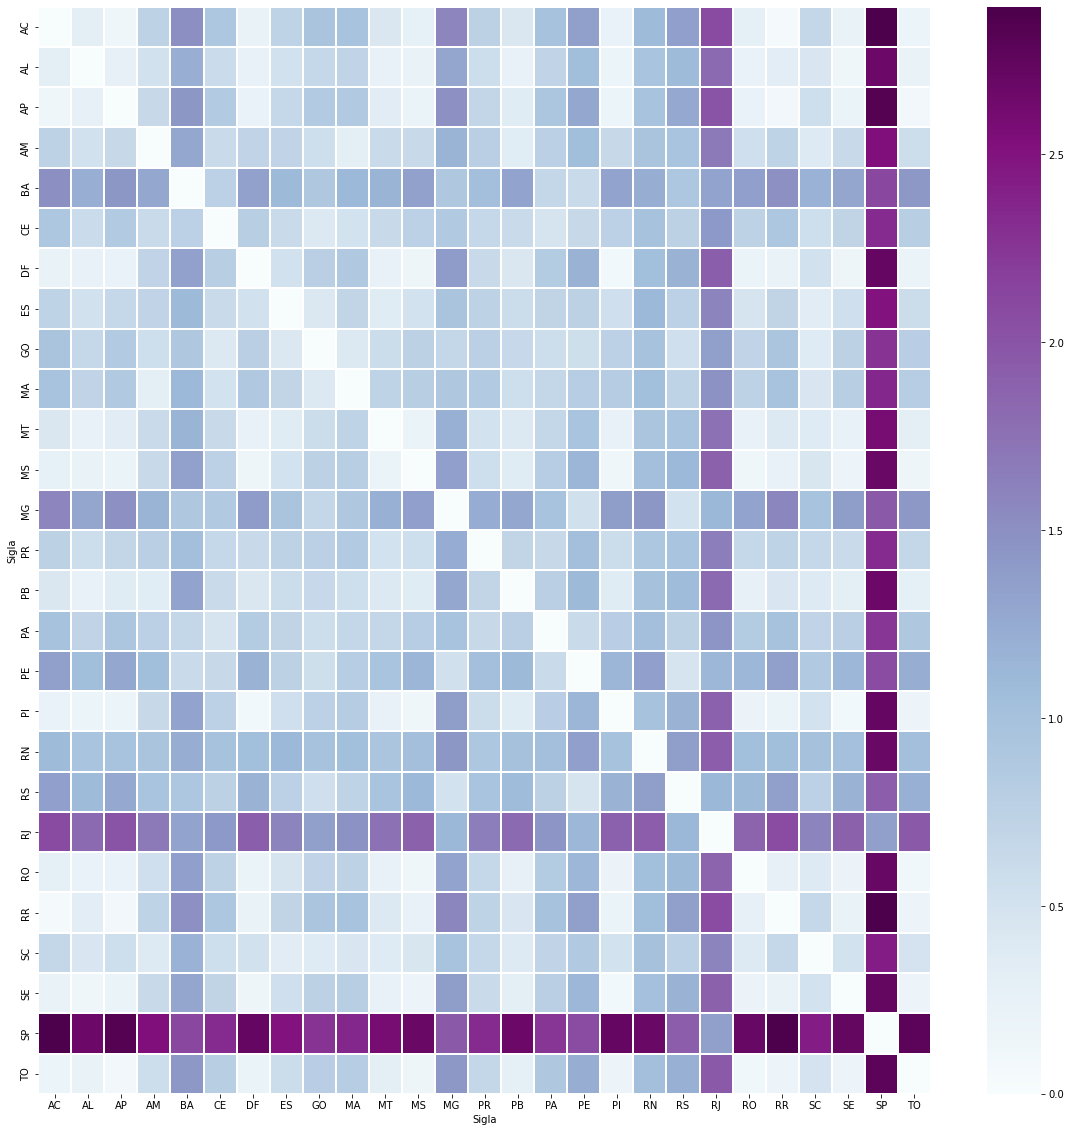

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(
    df_brasil_dist,
    cmap='BuPu',
    linewidth=1
)

Esse heatmap permite identificar os estados que são mais similares a partir dos dados fornecidos. A partir desse mapa podemos extrair a tabela a seguir:

In [ ]:
long_form = df_brasil_dist.unstack()

long_form.index.rename(['Estado A', 'Estado B'], inplace=True)
long_form = long_form.to_frame('distance').reset_index()

In [ ]:
long_form[
    (long_form['distance'] < 0.1) 
    & (long_form['Estado A'] != long_form['Estado B'])
]

,Estado A,Estado B,distance
22,AC,RR,0.048511
179,DF,PI,0.093248
465,PI,DF,0.093248
483,PI,SE,0.096149
594,RR,AC,0.048511
665,SE,PI,0.096149


A tabela acima mostra os estados que estão mais próximos, em outras palavras, os estados que são mais similares a partir das informações de crimes e ocorrências.

Acre e Roraima são estados com população pequena, próximos, vizinhos e pertencentes a mesma região. Esses fatos podem explicar o motivo da curta distância entre eles.




___

# Aplicação de clusterização

## Aplicando o K-Means

In [ ]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_brasil_norm[[*crimes, 'Populacao']])
    score_mean = metrics.silhouette_score(df_brasil_norm[[*crimes, 'Populacao']], kmeans.labels_, metric='euclidean')
    print(k, score_mean)

2 0.5015077712979866
3 0.4179704490026284
4 0.3374434755818512
5 0.3457202544556383
6 0.3508428267749326
7 0.3465448731152914
8 0.338265623079004
9 0.34339814815619635


In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_brasil_norm[[*crimes, 'Populacao']])

KMeans(n_clusters=2)

In [ ]:
clusters = kmeans.labels_.tolist()
clusters_dict = { 'siglas': list(df_brasil.Sigla), 'estado': df_brasil.UF, 'cluster': clusters}
dataframe_clusters = pd.DataFrame(clusters_dict, columns = ['cluster','siglas', 'estado'])

In [ ]:
dataframe_clusters

,cluster,siglas,estado
0,1,AC,Acre
1,1,AL,Alagoas
2,1,AP,Amapá
3,1,AM,Amazonas
4,0,BA,Bahia
5,1,CE,Ceará
6,1,DF,Distrito Federal
7,1,ES,Espírito Santo
8,1,GO,Goiás
9,1,MA,Maranhão


## Aplicando a clusterização Hierárquica

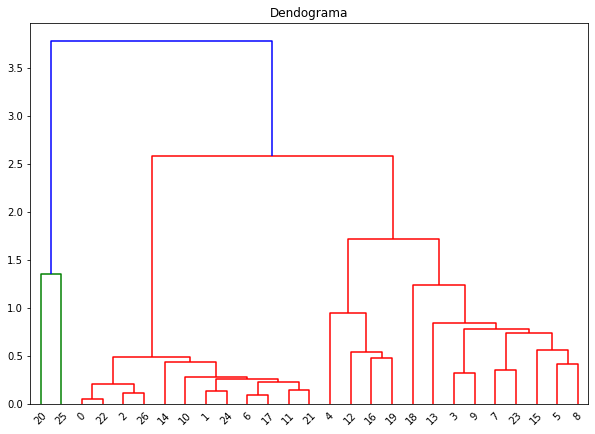

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dend = shc.dendrogram(shc.linkage(df_brasil_norm, method='ward'))

In [ ]:
agg_cluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=2)
agg_cluster.fit(df_brasil_norm[[*crimes, 'Populacao']])

AgglomerativeClustering()

In [ ]:
clusters_h = agg_cluster.labels_.tolist()
clusters_dict_h = { 'sigla': list(df_brasil.Sigla), 'estado': df_brasil.UF, 'cluster': clusters_h}
dataframe_clusters_h = pd.DataFrame(clusters_dict_h, columns = ['cluster','sigla', 'estado'])

In [ ]:
dataframe_clusters_h

,cluster,sigla,estado
0,0,AC,Acre
1,0,AL,Alagoas
2,0,AP,Amapá
3,0,AM,Amazonas
4,0,BA,Bahia
5,0,CE,Ceará
6,0,DF,Distrito Federal
7,0,ES,Espírito Santo
8,0,GO,Goiás
9,0,MA,Maranhão


In [ ]:
metrics.silhouette_score(df_brasil_norm, agg_cluster.labels_, metric='euclidean')

0.6130376433048236

In [ ]:
metrics.silhouette_score(df_brasil_norm, kmeans.labels_, metric='euclidean')

0.5015077712979866